### References:
- https://medium.com/@awjuliani/simple-reinforcement-learning-with-tensorflow-part-4-deep-q-networks-and-beyond-8438a3e2b8df

# Deep Q-Networks and Beyond
While our ordinary Q-network was able to barely perform as well as the Q-Table in a simple game environment, Deep Q-Networks are much more capable. In order to transform an ordinary Q-Network into a DQN we will be making the following improvements:

- Going from a single-layer network to a multi-layer convolutional network.
- Implementing Experience Replay, which will allow our network to train itself using stored memories from it’s experience.
- Utilizing a second “target” network, which we will use to compute target Q-values during our updates.


It was these three innovations that allowed the [Google DeepMind team to achieve superhuman performance on dozens of Atari games using their DQN agent](http://www.davidqiu.com:8888/research/nature14236.pdf). We will be walking through each individual improvement, and showing how to implement it. We won’t stop there though. The pace of Deep Learning research is extremely fast, and the DQN of 2014 is no longer the most advanced agent around anymore. I will discuss two simple additional improvements to the DQN architecture, Double DQN and Dueling DQN, that allow for improved performance, stability, and faster training time. In the end we will have a network that can tackle a number of challenging Atari games, and we will demonstrate how to train the DQN to learn a basic navigation task.



## Getting from Q-Network to Deep Q-Network

![](../docs/assets/rl/deepq_1.png)

### Addition 1: Convolutional Layers
Since our agent is going to be learning to play video games, it has to be able to make sense of the game’s screen output in a way that is at least similar to how humans or other intelligent animals are able to. Instead of considering each pixel independently, convolutional layers allow us to consider regions of an image, and maintain spatial relationships between the objects on the screen as we send information up to higher levels of the network. In this way, they act similarly to human receptive fields. Indeed there is a body of research showing that convolutional neural network learn representations that are similar to those of [the primate visual cortex](http://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1003963). As such, they are ideal for the first few elements within our network.

In Tensorflow, we can utilize the tf.contrib.layers.convolution2d function to easily create a convolutional layer. We write for function as follows:

```
convolution_layer = tf.contrib.layers.convolution2d(inputs,num_outputs,kernel_size,stride,padding)
```

Here num_outs refers to how many filters we would like to apply to the previous layer. kernel_size refers to how large a window we would like to slide over the previous layer. Stride refers to how many pixels we want to skip as we slide the window across the layer. Finally, padding refers to whether we want our window to slide over just the bottom layer (“VALID”) or add padding around it (“SAME”) in order to ensure that the convolutional layer has the same dimensions as the previous layer. For more information, see the Tensorflow documentation.

### Addition 2: Experience Replay
The second major addition to make DQNs work is Experience Replay. The basic idea is that by storing an agent’s experiences, and then randomly drawing batches of them to train the network, we can more robustly learn to perform well in the task. By keeping the experiences we draw random, we prevent the network from only learning about what it is immediately doing in the environment, and allow it to learn from a more varied array of past experiences. Each of these experiences are stored as a tuple of <state,action,reward,next state>. The Experience Replay buffer stores a fixed number of recent memories, and as new ones come in, old ones are removed. When the time comes to train, we simply draw a uniform batch of random memories from the buffer, and train our network with them. For our DQN, we will build a simple class that handles storing and retrieving memories.  

### Addition 3: Separate Target Network 
The third major addition to the DQN that makes it unique is the utilization of a second network during the training procedure. This second network is used to generate the target-Q values that will be used to compute the loss for every action during training. Why not use just use one network for both estimations? The issue is that at every step of training, the Q-network’s values shift, and if we are using a constantly shifting set of values to adjust our network values, then the value estimations can easily spiral out of control. The network can become destabilized by falling into feedback loops between the target and estimated Q-values. In order to mitigate that risk, the target network’s weights are fixed, and only periodically or slowly updated to the primary Q-networks values. In this way training can proceed in a more stable manner.

Instead of updating the target network periodically and all at once, we will be updating it frequently, but slowly. This technique was introduced in another [DeepMind paper](https://arxiv.org/pdf/1509.02971.pdf) earlier this year, where they found that it stabilized the training process.


## Going Beyond DQN
With the additions above, we have everything we need to replicate the DWN of 2014. But the world moves fast, and a number of improvements above and beyond the DQN architecture [described by DeepMind](http://www.davidqiu.com:8888/research/nature14236.pdf), have allowed for even greater performance and stability. Before training your new DQN on your favorite ATARI game, I would suggest checking the newer additions out. I will provide a description and some code for two of them: Double DQN, and Dueling DQN. Both are simple to implement, and by combining both techniques, we can achieve better performance with faster training times.

### Double DQN
The main intuition behind [Double DQN](http://www.aaai.org/ocs/index.php/AAAI/AAAI16/paper/download/12389/11847) is that the regular DQN often overestimates the Q-values of the potential actions to take in a given state. While this would be fine if all actions were always overestimates equally, there was reason to believe this wasn’t the case. You can easily imagine that if certain suboptimal actions regularly were given higher Q-values than optimal actions, the agent would have a hard time ever learning the ideal policy. In order to correct for this, the authors of DDQN paper propose a simple trick: instead of taking the max over Q-values when computing the target-Q value for our training step, we use our primary network to chose an action, and our target network to generate the target Q-value for that action. By decoupling the action choice from the target Q-value generation, we are able to substantially reduce the overestimation, and train faster and more reliably. Below is the new DDQN equation for updating the target value.

$$
Q-Target = \gamma + \gamma Q(s^`, a, \theta), \theta^`))
$$

### Dueling DQN

![](../docs/assets/rl/double_dqn.png)

Above: Regular DQN with a single stream for Q-values. Below: Dueling DQN where the value and advantage are calculated separately and then combined only at the final layer into a Q value.


In order to explain the reasoning behind the architecture changes that Dueling DQN makes, we need to first explain some a few additional reinforcement learning terms. The Q-values that we have been discussing so far correspond to how good it is to take a certain action given a certain state. This can be written as Q(s,a). This action given state can actually be decomposed into two more fundamental notions of value. The first is the value function V(s), which says simple how good it is to be in any given state. The second is the advantage function A(a), which tells how much better taking a certain action would be compared to the others. We can then think of Q as being the combination of V and A. More formally:

$$
Q(s,a) = V(s) + A(a)
$$

The goal of Dueling DQN is to have a network that separately computes the advantage and value functions, and combines them back into a single Q-function only at the final layer. It may seem somewhat pointless to do this at first glance. Why decompose a function that we will just put back together? The key to realizing the benefit is to appreciate that our reinforcement learning agent may not need to care about both value and advantage at any given time. For example: imagine sitting outside in a park watching the sunset. It is beautiful, and highly rewarding to be sitting there. No action needs to be taken, and it doesn’t really make sense to think of the value of sitting there as being conditioned on anything beyond the environmental state you are in. We can achieve more robust estimates of state value by decoupling it from the necessity of being attached to specific actions.



## Putting it all together

![](../docs/assets/rl/block_env_screenshot.png)

Simple block-world environment. The goal is to move the blue block to the green block while avoiding the red block.

Now that we have learned all the tricks to get the most out of our DQN, let’s actually try it on a game environment! While the DQN we have described above could learn ATARI games with enough training, getting the network to perform well on those games takes at least a day of training on a powerful machine. For educational purposes, I have built a simple game environment which our DQN learns to master in a couple hours on a moderately powerful machine. In the environment the agent controls a blue square, and the goal is to navigate to the green squares (reward +1) while avoiding the red squares (reward -1). At the start of each episode all squares are randomly placed within a 5x5 grid-world. The agent has 50 steps to achieve as large a reward as possible. Because they are randomly positioned, the agent needs to do more than simply learn a fixed path, as was the case in the FrozenLake environment from Tutorial 0. Instead the agent must learn a notion of spatial relationships between the blocks. And indeed, it is able to do just that!

The game environment outputs 84x84x3 color images, and uses function calls as similar to the OpenAI gym as possible. In doing so, it should be easy to modify this code to work on any of the OpenAI atari games. I encourage those with the time and computing resources necessary to try getting the agent to perform well in an ATARI game. The hyperparameters may need some tuning, but it is definitely possible. Good luck!

In [4]:
from __future__ import division

import gym
import numpy as np
import random
import tensorflow as tf
import tensorflow.contrib.slim as slim
import matplotlib.pyplot as plt
import scipy.misc
import os
%matplotlib inline

/home/mageswarand/anaconda3/envs/tensorflow1.0/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


## Load the game environment
Feel free to adjust the size of the gridworld. Making it smaller provides an easier task for our DQN agent, while making the world larger increases the challenge.

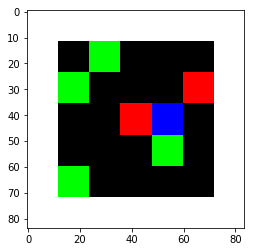

In [7]:
from gridworld import gameEnv

env = gameEnv(partial=False,size=5)

Above is an example of a starting environment in our simple game. The agent controls the blue square, and can move up, down, left, or right. The goal is to move to the green square (for +1 reward) and avoid the red square (for -1 reward). The position of the three blocks is randomized every episode.

### Implementing the network itself


In [8]:
class Qnetwork():
    def __init__(self,h_size):
        #The network recieves a frame from the game, flattened into an array.
        #It then resizes it and processes it through four convolutional layers.
        self.scalarInput =  tf.placeholder(shape=[None,21168],dtype=tf.float32)
        self.imageIn = tf.reshape(self.scalarInput,shape=[-1,84,84,3])
        self.conv1 = slim.conv2d( \
            inputs=self.imageIn,num_outputs=32,kernel_size=[8,8],stride=[4,4],padding='VALID', biases_initializer=None)
        self.conv2 = slim.conv2d( \
            inputs=self.conv1,num_outputs=64,kernel_size=[4,4],stride=[2,2],padding='VALID', biases_initializer=None)
        self.conv3 = slim.conv2d( \
            inputs=self.conv2,num_outputs=64,kernel_size=[3,3],stride=[1,1],padding='VALID', biases_initializer=None)
        self.conv4 = slim.conv2d( \
            inputs=self.conv3,num_outputs=h_size,kernel_size=[7,7],stride=[1,1],padding='VALID', biases_initializer=None)
        
        #We take the output from the final convolutional layer and split it into separate advantage and value streams.
        self.streamAC,self.streamVC = tf.split(self.conv4,2,3)
        self.streamA = slim.flatten(self.streamAC)
        self.streamV = slim.flatten(self.streamVC)
        xavier_init = tf.contrib.layers.xavier_initializer()
        self.AW = tf.Variable(xavier_init([h_size//2,env.actions]))
        self.VW = tf.Variable(xavier_init([h_size//2,1]))
        self.Advantage = tf.matmul(self.streamA,self.AW)
        self.Value = tf.matmul(self.streamV,self.VW)
        
        #Then combine them together to get our final Q-values.
        self.Qout = self.Value + tf.subtract(self.Advantage,tf.reduce_mean(self.Advantage,axis=1,keep_dims=True))
        self.predict = tf.argmax(self.Qout,1)
        
        #Below we obtain the loss by taking the sum of squares difference between the target and prediction Q values.
        self.targetQ = tf.placeholder(shape=[None],dtype=tf.float32)
        self.actions = tf.placeholder(shape=[None],dtype=tf.int32)
        self.actions_onehot = tf.one_hot(self.actions,env.actions,dtype=tf.float32)
        
        self.Q = tf.reduce_sum(tf.multiply(self.Qout, self.actions_onehot), axis=1)
        
        self.td_error = tf.square(self.targetQ - self.Q)
        self.loss = tf.reduce_mean(self.td_error)
        self.trainer = tf.train.AdamOptimizer(learning_rate=0.0001)
        self.updateModel = self.trainer.minimize(self.loss)

### Experience Replay¶
This class allows us to store experies and sample then randomly to train the network.

In [9]:
class experience_buffer():
    def __init__(self, buffer_size = 50000):
        self.buffer = []
        self.buffer_size = buffer_size
    
    def add(self,experience):
        if len(self.buffer) + len(experience) >= self.buffer_size:
            self.buffer[0:(len(experience)+len(self.buffer))-self.buffer_size] = []
        self.buffer.extend(experience)
            
    def sample(self,size):
        return np.reshape(np.array(random.sample(self.buffer,size)),[size,5])

This is a simple function to resize our game frames.

In [10]:
def processState(states):
    return np.reshape(states,[21168])

These functions allow us to update the parameters of our target network with those of the primary network.

In [11]:
def updateTargetGraph(tfVars,tau):
    total_vars = len(tfVars)
    op_holder = []
    for idx,var in enumerate(tfVars[0:total_vars//2]):
        op_holder.append(tfVars[idx+total_vars//2].assign((var.value()*tau) + ((1-tau)*tfVars[idx+total_vars//2].value())))
    return op_holder

def updateTarget(op_holder,sess):
    for op in op_holder:
        sess.run(op)


### Training the network
Setting all the training parameters

In [12]:
batch_size = 32 #How many experiences to use for each training step.
update_freq = 4 #How often to perform a training step.
y = .99 #Discount factor on the target Q-values
startE = 1 #Starting chance of random action
endE = 0.1 #Final chance of random action
annealing_steps = 10000. #How many steps of training to reduce startE to endE.
num_episodes = 10000 #How many episodes of game environment to train network with.
pre_train_steps = 10000 #How many steps of random actions before training begins.
max_epLength = 50 #The max allowed length of our episode.
load_model = False #Whether to load a saved model.
path = "./dqn" #The path to save our model to.
h_size = 512 #The size of the final convolutional layer before splitting it into Advantage and Value streams.
tau = 0.001 #Rate to update target network toward primary network

In [13]:
tf.reset_default_graph()
mainQN = Qnetwork(h_size)
targetQN = Qnetwork(h_size)

init = tf.global_variables_initializer()

saver = tf.train.Saver()

trainables = tf.trainable_variables()

targetOps = updateTargetGraph(trainables,tau)

myBuffer = experience_buffer()

#Set the rate of random action decrease. 
e = startE
stepDrop = (startE - endE)/annealing_steps

#create lists to contain total rewards and steps per episode
jList = []
rList = []
total_steps = 0

#Make a path for our model to be saved in.
if not os.path.exists(path):
    os.makedirs(path)

with tf.Session() as sess:
    sess.run(init)
    if load_model == True:
        print('Loading Model...')
        ckpt = tf.train.get_checkpoint_state(path)
        saver.restore(sess,ckpt.model_checkpoint_path)
    for i in range(num_episodes):
        episodeBuffer = experience_buffer()
        #Reset environment and get first new observation
        s = env.reset()
        s = processState(s)
        d = False
        rAll = 0
        j = 0
        #The Q-Network
        while j < max_epLength: #If the agent takes longer than 200 moves to reach either of the blocks, end the trial.
            j+=1
            #Choose an action by greedily (with e chance of random action) from the Q-network
            if np.random.rand(1) < e or total_steps < pre_train_steps:
                a = np.random.randint(0,4)
            else:
                a = sess.run(mainQN.predict,feed_dict={mainQN.scalarInput:[s]})[0]
            s1,r,d = env.step(a)
            s1 = processState(s1)
            total_steps += 1
            episodeBuffer.add(np.reshape(np.array([s,a,r,s1,d]),[1,5])) #Save the experience to our episode buffer.
            
            if total_steps > pre_train_steps:
                if e > endE:
                    e -= stepDrop
                
                if total_steps % (update_freq) == 0:
                    trainBatch = myBuffer.sample(batch_size) #Get a random batch of experiences.
                    #Below we perform the Double-DQN update to the target Q-values
                    Q1 = sess.run(mainQN.predict,feed_dict={mainQN.scalarInput:np.vstack(trainBatch[:,3])})
                    Q2 = sess.run(targetQN.Qout,feed_dict={targetQN.scalarInput:np.vstack(trainBatch[:,3])})
                    end_multiplier = -(trainBatch[:,4] - 1)
                    doubleQ = Q2[range(batch_size),Q1]
                    targetQ = trainBatch[:,2] + (y*doubleQ * end_multiplier)
                    #Update the network with our target values.
                    _ = sess.run(mainQN.updateModel, \
                        feed_dict={mainQN.scalarInput:np.vstack(trainBatch[:,0]),mainQN.targetQ:targetQ, mainQN.actions:trainBatch[:,1]})
                    
                    updateTarget(targetOps,sess) #Update the target network toward the primary network.
            rAll += r
            s = s1
            
            if d == True:

                break
        
        myBuffer.add(episodeBuffer.buffer)
        jList.append(j)
        rList.append(rAll)
        #Periodically save the model. 
        if i % 1000 == 0:
            saver.save(sess,path+'/model-'+str(i)+'.ckpt')
            print("Saved Model")
        if len(rList) % 10 == 0:
            print(total_steps,np.mean(rList[-10:]), e)
    saver.save(sess,path+'/model-'+str(i)+'.ckpt')
print("Percent of succesful episodes: " + str(sum(rList)/num_episodes) + "%")

Saved Model
500 2.4 1
1000 2.2 1
1500 2.5 1
2000 2.5 1
2500 2.4 1
3000 2.1 1
3500 1.5 1
4000 3.3 1
4500 2.4 1
5000 0.7 1
5500 2.9 1
6000 0.9 1
6500 1.1 1
7000 2.8 1
7500 3.2 1
8000 3.2 1
8500 1.3 1
9000 1.4 1
9500 1.4 1
10000 1.5 1
10500 2.3 0.9549999999999828
11000 1.5 0.9099999999999655
11500 3.8 0.8649999999999483
12000 1.7 0.819999999999931
12500 2.7 0.7749999999999138
13000 1.0 0.7299999999998965
13500 2.8 0.6849999999998793
14000 2.2 0.639999999999862
14500 2.2 0.5949999999998448
15000 1.9 0.5499999999998275
15500 2.6 0.5049999999998103
16000 2.1 0.4599999999998177
16500 1.7 0.41499999999982823
17000 1.2 0.36999999999983874
17500 3.3 0.32499999999984924
18000 2.4 0.27999999999985975
18500 1.2 0.23499999999986562
19000 2.8 0.18999999999986225
19500 1.8 0.14499999999985888
20000 1.6 0.09999999999985551
20500 2.9 0.09999999999985551
21000 1.8 0.09999999999985551
21500 3.1 0.09999999999985551
22000 1.5 0.09999999999985551
22500 5.0 0.09999999999985551
23000 3.6 0.09999999999985551
23

KeyboardInterrupt: 

### Checking network learning
Mean reward over time

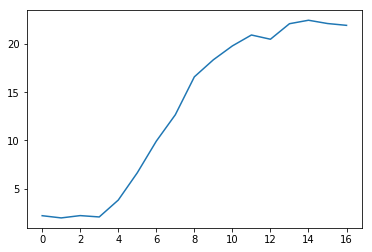

In [14]:
rMat = np.resize(np.array(rList),[len(rList)//100,100])
rMean = np.average(rMat,1)
plt.plot(rMean)